# MCMC

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import emcee

Generamos datos experimentales

Text(0, 0.5, 'y')

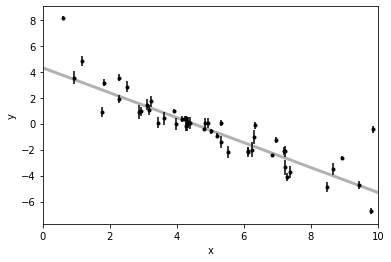

In [12]:
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534 # Subestimación en los errores

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true # Lineal
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

Ajustamos por Mínimos Cuadrados

Estimación por mínimos cuadrados:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


Text(0, 0.5, 'y')

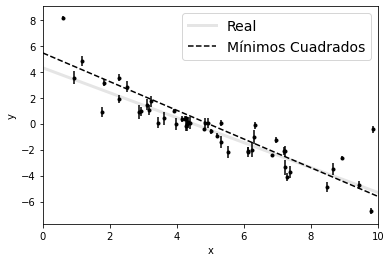

In [13]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
print("Estimación por mínimos cuadrados:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

m_ls  = w[0]
dm_ls = np.sqrt(cov[0, 0])
b_ls  = w[1]
db_ls = np.sqrt(cov[1, 1])

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.1, lw=3, label="Real")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="Mínimos Cuadrados")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

Ajustamos por Maximum Likelihood

In [14]:
# Definimos nuestro modelo a ajustar a los datos

def fit_model(x,*args):
    m = args[0]
    b = args[1]
    return m * x + b

In [15]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = fit_model(x,m,b)
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


Text(0, 0.5, 'y')

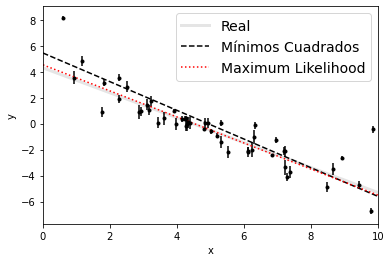

In [16]:
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_ls, b_ls, np.log(0.001)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.1, lw=3, label="Real")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="Mínimos Cuadrados")
plt.plot(x0, m_ml * x0 + b_ml, ":r", label="Maximum Likelihood")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

## Estimación de error por MCMC (Monte Carlo Markov Chain)

Las cadenas de Markov son un modelo estocástico que describe una secuencia de posibles eventos en los cuales la probabilidad de que cada evento suceda, depende unicamente del resultado obtenido en el evento anterior. Una técnica para hacer esta secuencia estocástica es usando objetos matemáticos que se comporten de esta forma, e.g., los caminantes aleatorios.

La técnica MCMC utiliza las ventajas de las Markov Chains para estimar la distribución de probabilidad a posteriori utilizando los resultados anteriores, combinados con las venajas de la técnica Monte Carlo de hacerlo varias veces.

En este punto lo que nos gustaría es tener un margen sobre los parámetros desconocidos y estimar la función de probabilidad a posteriori (la distribución de parámetros consistente con nuestros datos). La técnica de MCMC permite hacer estas dos cosas.

La distribución de probabilidad a posteriori nos indica cuál es la probabilidad de obtener parámetros de un modelo dados los datos, es decir,

$$
p(\text{parámetros} | \text{datos}) \propto p(\text{parámetros}) p(y|\text{parámetros y mediciones}),
$$

donde ya sabemos que $p(y|\text{parámetros})$ es la función likelihood y nos falta conocer la distribución a *priori* $ p(\text{parámetros})$.

Esta función codifica cualquier conocimiento previo que tengamos sobre los parámetros:

- Resultados de otros experimentos.
- Límites físicos aceptables.
- Estimaciones teóricas.
- etc...

La distribución a priori es complicada de obtener ya que puede ser muy complicada en su forma funcional. Lo más sencillo es suponer que cada parámetro es independiente, de esta forma, si tenemos parámetros $a_1$, $a_2$ y $a_3$, entonces:

$$
p(a_1,a_2,a_3) = p_1(a_1) p_2(a_2) p_3(a_3),
$$

sin embargo, los parámetros podrían ser dependientes entre sí, lo cual complica más las cosas. Todo esto depende de lo que sepas de antemano de tu problema, modelo, etc.

Para este caso tenemos parámetros $m$, $b$ y $f$. Supondremos que 
$$
p(m,b,f) = p_m(m) p_b(b) p_f(f),
$$

y cada una de las distribuciones para cada parámetro es uniforme. De esta forma podemos definir la función log de priori como:

In [17]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

Esta función regresa $\ln p = 0$, i.e, $p(m,b,f) = 1$, si $-5 < m < 0.5$, $0 < b < 10$ y $10^{-10} < f < 0$ aunque formalmente debería ser un valor $\kappa =$ constante. Pero lo que nos interesa es la proporcionalidad, no tanto el valor constante de la distribución uniforme.

Añadimos la log prior function a la función likelihood para obtener la distribución a posteriori:

In [18]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

Ya que tenemos la forma de la distribución a posteriori la usamos en el esquema de MCMC para obtener la distribución de los parámetros que mejor se ajusta a nuestras observaciones.

Para esto dejaremos que 32 caminantes aleatorios, que partirán de una pequeña bola Gaussiana alrededor de la MLE (estimación del maximum likelihood), se muevan a lo largo de una cadena de 5000 pasos.

In [22]:
# La MLE es soln.x. 32 caminantes aleatorios y 3 parámetros del modelo
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 500, progress=True)

100%|██████████| 500/500 [00:00<00:00, 869.98it/s]


State([[-0.97116526  4.41946444 -0.7884222 ]
 [-1.07999413  4.88995635 -0.75174647]
 [-0.9976181   4.41794564 -0.75110914]
 [-0.94530177  4.35661901 -0.85011438]
 [-1.00890054  4.56621791 -0.95499625]
 [-1.12094776  5.14520314 -0.83510388]
 [-0.91136994  4.11823925 -0.61696961]
 [-1.09079167  4.82056807 -0.76440347]
 [-1.00120481  4.49737541 -0.58043624]
 [-0.93095718  4.154416   -0.77324594]
 [-0.98279026  4.40612516 -0.77689645]
 [-1.05460396  4.76680971 -0.70414048]
 [-0.96042303  4.36354574 -0.8914116 ]
 [-1.01242666  4.58926674 -0.82383095]
 [-1.14818251  5.34254068 -0.83242168]
 [-0.91838463  4.05953432 -0.8799538 ]
 [-1.032139    4.50947864 -0.94748885]
 [-0.99368623  4.45953094 -0.84162214]
 [-1.29922652  5.80647613 -0.86658585]
 [-0.89872183  4.05414056 -0.65211229]
 [-0.95658591  4.36657109 -0.65903982]
 [-1.05088129  4.71282035 -0.81489692]
 [-1.0480935   4.56446287 -0.49951536]
 [-1.14382794  5.13303528 -0.70463862]
 [-0.82711324  3.70771924 -0.2697064 ]
 [-1.09068684  4.89

Veamos la "serie de tiempo" de los parámetros

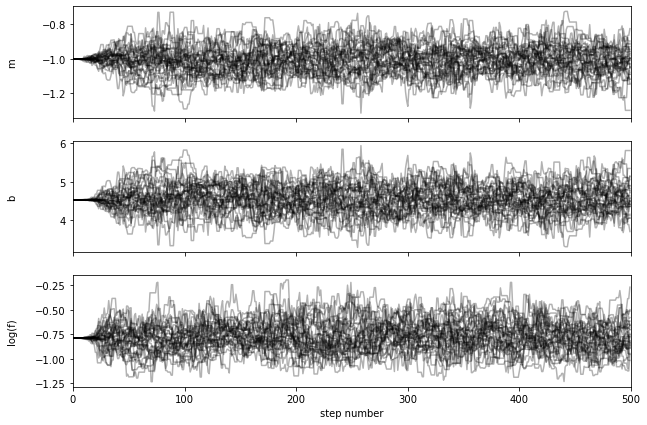

In [23]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Veamos después de cuántos pasos los caminantes se "olvidan" de su posición inicial, a esto se le llama tiempo de autocorrelación:

In [24]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [23.90603376 23.69838857 19.58288784]

Lo que haremos ahora será entonces quitar los primeros 100 pasos de la caminata y apartir de ahí tomar los valores cada 15 pasos (lo que corresponde a la mitad del tiempo de autocorrelación):

In [25]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(832, 3)


## Resultados

Ya que redujimos la lista de parámetros, realizaremos un "corner plot":

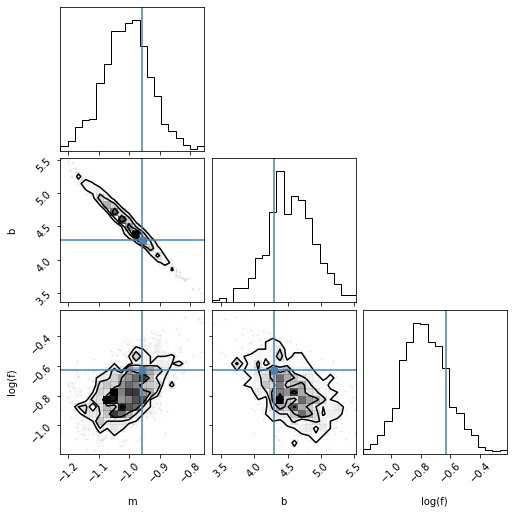

In [26]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

Finalmente grafiquemos todos los posibles modelos utilizando la lista de parámetros que obtuvimos:

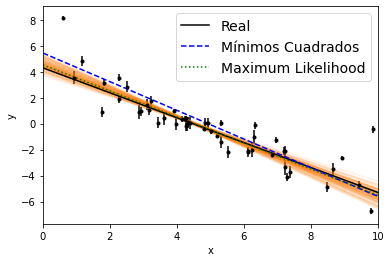

In [27]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="Real")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--b", label="Mínimos Cuadrados")
plt.plot(x0, m_ml * x0 + b_ml, ":g", label="Maximum Likelihood")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Y obtengamos los parámetros promedio con sus incertidumbres, considerando los percentiles 16, 50 y 84.

Nota: Los percentiles son una medida de posición usada en estadística que indica, una vez ordenados los datos de menor a mayor, el valor de la variable por debajo del cual se encuentra un porcentaje dado de observaciones de un grupo.

Es decir, si tomamos los percentiles 16 y 84, estamos descartando los valores que tienen un 16% de probabilidad de ambos lados de la distribución. El percentil 50 es justo la media.

In [28]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

En este caso 16% de la distribución en $b$ es menor a 4.557 - 0.350, mientras que otro 16% de la distribución es mayor a 4.557 + 0.366.